<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.9.16


In [4]:
import time
import os
import sys
import pandas as pd
import json
from pyjedai.datamodel import Data
from pyjedai.workflow import PYJEDAIWorkFlow, compare_workflows, ProgressiveWorkFlow
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.utils import to_path, necessary_dfs_supplied, values_given
#-EDIT-THOSE-#
# path of the configuration file
CONFIG_FILE_PATH = to_path('~/pyJedAI/pyJedAI-Dev/script-configs/per_experiments.json')
# which configuration from the json file should be used in the current experiment  
EXPERIMENT_NAME = 'gsn-test-multiple-iterations'
# path at which the results will be stored within a json file
RESULTS_STORE_PATH = to_path('~/pyJedAI/pyJedAI-Dev/script-results/' + EXPERIMENT_NAME + '.json')
# number of the current dataset
dataset_id = 2
id = 0
##############                          
                                   
with open(CONFIG_FILE_PATH) as file:
    config = json.load(file)
    
config = config[EXPERIMENT_NAME]
if(not necessary_dfs_supplied(config)):
    raise ValueError("Different number of source, target dataset and ground truth paths!")

d1_path = config['source_dataset_path'][id]
d2_path = config['target_dataset_path'][id]
gt_path = config['ground_truth_path'][id]
dataset_name = config['dataset_name'][id] if(values_given(config, 'dataset_name') and len(config['dataset_name']) > id) else ("D" + str(dataset_id))

d1 = pd.read_csv(to_path(d1_path), sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv(to_path(d2_path), sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv(to_path(gt_path), sep='|', engine='python')

d1_attributes = config['d1_attributes'][id] if values_given(config, 'd1_attributes') else d1.columns.tolist()
d2_attributes = config['d2_attributes'][id] if values_given(config, 'd2_attributes') else d2.columns.tolist()

data = Data(
    dataset_1=d1,
    attributes_1=d1_attributes,
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=d2_attributes,
    id_column_name_2='id',
    ground_truth=gt,
)

In [6]:
df = pd.read_csv("../script-results/gsn-test-multiple-iterations.csv")
print(df)

        matcher algorithm indexing weighting_scheme  window_size  budget  \
0    GlobalPSNM       TOP  inorder              ACF            3      49   
1    GlobalPSNM       TOP  inorder              ACF            3      49   
2    GlobalPSNM       TOP  inorder              ACF            3      49   
3    GlobalPSNM       TOP  inorder              ACF           10      49   
4    GlobalPSNM       TOP  inorder              ACF           10      49   
..          ...       ...      ...              ...          ...     ...   
475  GlobalPSNM        HB  inorder               ID            3     490   
476  GlobalPSNM        HB  inorder               ID            3     490   
477  GlobalPSNM        HB  inorder               ID           10     490   
478  GlobalPSNM        HB  inorder               ID           10     490   
479  GlobalPSNM        HB  inorder               ID           10     490   

    dataset  total_candidates  total_emissions      time  \
0      D100                

# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking: 100%|██████████| 200/200 [00:00<00:00, 33557.12it/s]


In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0499 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering: 100%|██████████| 3/3 [00:00<00:00, 21.27it/s]


# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging: 100%|██████████| 6216/6216 [00:00<00:00, 463259.72it/s]


In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 2491.0
Runtime: 0.0145 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.13% 
	Recall:        99.54%
	F1-score:       2.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1071
	False positives: 93330
	True negatives: 1064441
	False negatives: 5
	Total comparisons: 94401
─────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 1.1345218800648298,
 'Recall %': 99.53531598513011,
 'F1 %': 2.2434722498612234,
 'True Positives': 1071,
 'False Positives': 93330,
 'True Negatives': 1064441,
 'False Negatives': 5}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [11]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM,
    WhooshPM
)

In [62]:
from pyjedai.evaluation import Evaluation

test_workflow_1 = ProgressiveWorkFlow()
test_workflow_1.run(data=data, budget=10000, matcher='GlobalPSNM', weighting_scheme='ID', emit_all_tps_stop=True, window_size=3, algorithm='HB', indexing='bilateral')

{'weighting_scheme': 'ID', 'window_size': 3}
{'budget': 10000, 'algorithm': 'HB', 'indexing': 'bilateral', 'emit_all_tps_stop': True}
dice


Global Progressive Sorted Neighborhood Matching (dice):   0%|          | 0/297 [00:00<?, ?it/s]


In [63]:
test_workflow_2 = ProgressiveWorkFlow()
test_workflow_2.run(data=data, budget=10000, matcher='LocalPSNM', weighting_scheme='ID', emit_all_tps_stop=True, window_size=3, algorithm='HB', indexing='bilateral')

{'weighting_scheme': 'ID', 'window_size': 3}
{'budget': 10000, 'algorithm': 'HB', 'indexing': 'bilateral', 'emit_all_tps_stop': True}
dice


Global Progressive Sorted Neighborhood Matching (dice):   0%|          | 0/297 [00:00<?, ?it/s]


In [66]:
matchers = []
matchers.append(test_workflow_1.progressive_matcher)
matchers.append(test_workflow_2.progressive_matcher)


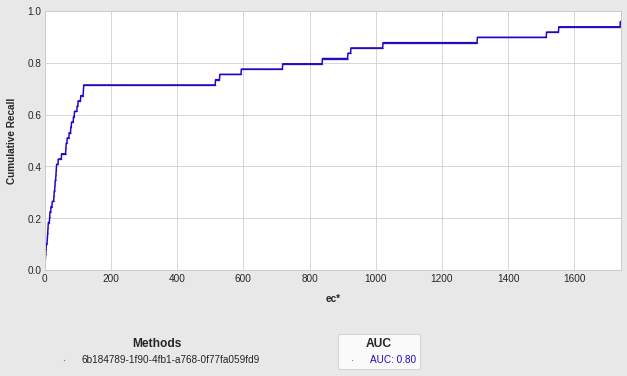

CPU times: user 122 ms, sys: 84.8 ms, total: 207 ms
Wall time: 87.2 ms


In [67]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers = matchers, proportional = False)

In [49]:
print(f'Total Emissions: {test_workflow_1.progressive_matcher.get_total_emissions()}')
print(f'Cumulative Recall: {test_workflow_1.progressive_matcher.get_cumulative_recall()}')
print(f'Normalized AUC: {test_workflow_1.progressive_matcher.get_normalized_auc()}')

Total Emissions: 1175
Cumulative Recall: 0.9183673469387755
Normalized AUC: 0.7160037484381623


In [38]:
print(f'Total Emissions: {test_workflow_2.progressive_matcher.get_total_emissions()}')
print(f'Cumulative Recall: {test_workflow_2.progressive_matcher.get_cumulative_recall()}')
print(f'Normalized AUC: {test_workflow_2.progressive_matcher.get_normalized_auc()}')

Total Emissions: 5471
Cumulative Recall: 1.0
Normalized AUC: 0.6283342284282062
